# Module 4 - Lab 2 - LLM Enhance LLM Application - RAG 
## Pre-requisites
> handled by codespace custom initialization
- ollama installed and running 
- python packages 
    - langchain
    - langchain-openai
    - langgraph

### Python package 
- `pypdf` for parsing PDF
- `chroma` for Vector database
- `langchain_chroma` wrapper for Chroma vector DB

In [12]:
!pip install --upgrade pypdf chroma langchain_chroma

  Using cached langchain_chroma-0.2.2-py3-none-any.whl.metadata (1.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 17.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached chromadb-0.6.3-py3-none-any.whl.metadata (6.8 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached uvicorn-0.34.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached opentelemetry_api-1.30.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.30.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached opentelemetry_instrumentation_fastapi-0.51b0-py3-none-any.whl.metadata (2.2 kB)
  Using cached opentelemetry_sdk-1.30.0-py3-none-any.whl.met

### Ollama
- Download embedded model

In [1]:
!ollama pull nomic-embed-text:latest

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling 970aa74c0a90... 100% ▕████████████████▏ 274 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling ce4a164fc046... 100% ▕████████████████▏   17 B                         
pulling 31df23ea7daa... 100% ▕████████████████▏  420 B                         
verifying sha256 digest 
writing manifest 
success 


- Download llama-3.2

In [18]:
!ollama pull llama3.2:1b-instruct-q4_0

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling b98b382ad859... 100% ▕████████████████▏ 770 MB                         
pulling 966de95ca8a6... 100% ▕████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da... 100% ▕████████████████▏ 7.7 KB                         
pulling a70ff7e570d9... 100% ▕████████████████▏ 6.0 KB                         
pulling e9e2eec515fb... 100% ▕████████████████▏  485 B                         
verifying sha256 digest 
writing manifest 
success 


In [19]:
!ollama list

NAME                                                 ID              SIZE      MODIFIED       
llama3.2:1b-instruct-q4_0                            53f2745c8077    770 MB    2 seconds ago     
nomic-embed-text:latest                              0a109f422b47    274 MB    10 minutes ago    
llama3.2:1b                                          baf6a787fdff    1.3 GB    2 days ago        
hf.co/bartowski/Llama-3.2-1B-Instruct-GGUF:IQ4_XS    0c8e6e099ddb    743 MB    2 weeks ago       
llama3.2:3b                                          a80c4f17acd5    2.0 GB    3 weeks ago       
deepseek-r1:1.5b                                     a42b25d8c10a    1.1 GB    3 weeks ago       


## High-Level Overview

### Indexing


# Indexing
- typically done offline
- steps
    - load data
        - with **Document Loaders**
    - split
        - with **Text splitters** to break the doc into smaller chunks
    - embed
        - transform human language into format (vector) that machines can understand and compare with speed/accuracy
    - store
        - persist so we can later search
        - often done with **VectorStore**

## Load Data

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(
    file_path = "../misc/sample_travel_policy.pdf",
    # headers = None
    # password = None,
    mode = "single", # for entire document instead of page-wise extraction
    pages_delimiter = "===",
    extract_images = False,
)

In [ ]:
docs = []
docs_lazy = loader.lazy_load()

for doc in docs_lazy:
    docs.append(doc)

In [19]:
# Peek into what the docs look like
print(f"Number of docs {len(docs)}")
vars(docs[0])

Number of docs 1


{'id': None,
 'metadata': {'producer': 'Microsoft® Word for Microsoft 365',
  'creator': 'Microsoft® Word for Microsoft 365',
  'creationdate': '2024-04-19T11:39:22+08:00',
  'moddate': '2024-04-19T15:47:16+08:00',
  'source': './sample_travel_policy.pdf',
  'total_pages': 45},
 'page_content': "Celebrate living  \nfwd.com.sg \nFWD Travel insurance  \nPolicy wording \nThis is your contract for your insurance policy. \nRead it to understand all the benefits as well as the important terms and conditions  \nthat apply to your insurance cover. Don’t worry, we’ve made it as easy to read as possible. \nIf you need help, call our hotline: +65 6820 8888===Quick reference \nV4 | Apr 2024 \nAbout your policy 1 \nWords with special meaning  \nWho can buy this policy  \nNo cover for travel to certain countries  \nYour policy \n1  \n1  \n2  \n2 \nStarting or ending your policy 35 \nWhen your policy starts   \nWhen your policy ends   \nYour right to cancel   \nOur right to cancel \n35  \n35  \n36  \

## Split Document

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, # characters
    chunk_overlap=200, # characters
    add_start_index=True, # track index in original doc
    )
all_splits = text_splitter.split_documents(docs)

print(f"Split document into {len(all_splits)} sub-documents.")

Split document into 125 sub-documents.


## Embedding

In [8]:
from langchain_openai import OpenAIEmbeddings
embeddings  = OpenAIEmbeddings(
    # openai_api_base="http://localhost:1234/v1", # LM Studio
    openai_api_base="http://localhost:11434/v1", # Ollama   
    model="nomic-embed-text", # must match embedding model available on ollama
    api_key="not_used",
    check_embedding_ctx_length=False
    )

- Peek into what an embedding look like

In [9]:
from pprint import pprint
# Demo on what vector looks like
query = "this is my embedding"
vector = embeddings.embed_query(query)
print(f"number of elements in vector {len(vector)}")
pprint(vector)

number of elements in vector 768
[0.0017875752,
 0.03661727,
 -0.13027693,
 -0.072554365,
 -0.000977685,
 -0.037199687,
 0.033047833,
 0.001959978,
 -0.0005396232,
 -0.054814897,
 -0.04628785,
 6.81945e-05,
 0.019856613,
 0.024816703,
 -0.011389883,
 0.06335445,
 0.023242949,
 -0.080821946,
 -0.008799684,
 0.054557417,
 -0.07664555,
 -0.0117019275,
 -0.01632399,
 0.009374603,
 0.09953933,
 0.04233486,
 0.05488499,
 0.0089654885,
 -0.047863014,
 -0.011821106,
 0.020408249,
 -0.004247267,
 0.0018705406,
 -0.0047371085,
 -0.0045369915,
 -0.027423214,
 -0.017687261,
 0.045793723,
 0.050576817,
 0.0032008165,
 0.010816007,
 0.0032508867,
 -0.035671066,
 0.0014058311,
 -0.034438793,
 -0.025888234,
 0.08249343,
 -0.051746868,
 0.028701602,
 -0.042818222,
 0.0106454855,
 0.019631984,
 -0.039314993,
 -0.07022645,
 0.07483102,
 -0.059343264,
 -0.0007987259,
 0.019459333,
 0.021273274,
 -0.017768145,
 0.05648034,
 0.06295692,
 -0.05950391,
 0.09003479,
 0.012842579,
 0.030542623,
 -0.09989499,
 0

## Store 

In [13]:
from langchain_chroma import Chroma

# Add to vectorDB
vector_store = Chroma.from_documents(
    documents=all_splits,
    collection_name="travel_policy",
    #persist_directory='chroma',
    embedding=embeddings,
)

In [14]:
vars(vector_store)

{'_client_settings': Settings(environment='', chroma_api_impl='chromadb.api.segment.SegmentAPI', chroma_server_nofile=None, chroma_server_thread_pool_size=40, tenant_id='default', topic_namespace='default', chroma_server_host=None, chroma_server_headers=None, chroma_server_http_port=None, chroma_server_ssl_enabled=False, chroma_server_ssl_verify=None, chroma_server_api_default_path=<APIVersion.V2: '/api/v2'>, chroma_server_cors_allow_origins=[], is_persistent=False, persist_directory='./chroma', chroma_memory_limit_bytes=0, chroma_segment_cache_policy=None, allow_reset=False, chroma_auth_token_transport_header=None, chroma_client_auth_provider=None, chroma_client_auth_credentials=None, chroma_server_auth_ignore_paths={'APIVersion.V2': ['GET'], 'APIVersion.V2/heartbeat': ['GET'], 'APIVersion.V2/version': ['GET'], 'APIVersion.V1': ['GET'], 'APIVersion.V1/heartbeat': ['GET'], 'APIVersion.V1/version': ['GET']}, chroma_overwrite_singleton_tenant_database_access_from_auth=False, chroma_serve

In [15]:
# Peek at how it retrieves
results = vector_store.similarity_search(
    query="does my policy cover baggage lost or damage",
    k=2,
)

In [16]:
from pprint import pprint

for res in results:
    pprint(f"* content:{res.page_content[:100]}...")
    pprint(f"  metadata:[{res.metadata}]")

('* content:baggage delay from the public transport provider or \n'
 'their handling agents stating your name, date, ...')
("  metadata:[{'creationdate': '2024-04-19T11:39:22+08:00', 'creator': "
 "'Microsoft® Word for Microsoft 365', 'moddate': '2024-04-19T15:47:16+08:00', "
 "'producer': 'Microsoft® Word for Microsoft 365', 'source': "
 "'../misc/sample_travel_policy.pdf', 'start_index': 27327, 'total_pages': "
 '45}]')
('* content:under your care, or in the care of another \n'
 'authorised person (including transport and \n'
 'accommodatio...')
("  metadata:[{'creationdate': '2024-04-19T11:39:22+08:00', 'creator': "
 "'Microsoft® Word for Microsoft 365', 'moddate': '2024-04-19T15:47:16+08:00', "
 "'producer': 'Microsoft® Word for Microsoft 365', 'source': "
 "'../misc/sample_travel_policy.pdf', 'start_index': 29742, 'total_pages': "
 '45}]')


# Retrieval and Generation
- Given user input
    - relevant splits are retrieved from vector storage using **Retriever**
- Generate
    - LLM produces an answer using a prompt that includes both the question and the retrieved data

### Setup Prompt

In [17]:
from langchain import hub

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/Users/jasonlau/.pyenv/versions/3.13.1/envs/venv/lib/python3.13/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


### Setup Graph

In [20]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    #base_url="http://localhost:1234/v1", # LM Studio 
    base_url="http://localhost:11434/v1", # Ollama   
    api_key="not_used",
    model="llama3.2:1b-instruct-q4_0",
    temperature=0,
    )

In [21]:
from langgraph.graph import MessagesState 
from langgraph.graph import StateGraph, START, END
from langchain_core.documents import Document
from typing_extensions import List

class State(MessagesState):
    question: str
    context: List[Document]
    answer: str

# Define application steps
def retrieve(state:State):
    retrieved_docs = vector_store.similarity_search(
        query=state["question"],
        #k=4, # number of results to return, default 4
        )
    return {"context": retrieved_docs}


def generate(state:State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
workflow = StateGraph(State)
workflow.add_node("retrieve", retrieve) 
workflow.add_node("generate", generate) 
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)
graph = workflow.compile()

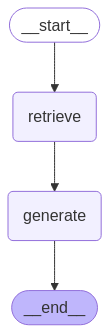

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Execute

In [23]:
from pprint import pprint

response = graph.invoke({"question": "Does my policy cover missing or damage baggage ?"})
pprint(response["answer"])

('Your policy covers missing or damaged baggage, but excludes items like '
 'perishables or consumables, motorised vehicles, traveller cards, credit '
 'value-loaded cards, prepaid debit cards, theft of personal belongings, and '
 'damage to personal belongings. It also has specific rules for treating '
 'damaged items as lost, such as setting a single amount per pair or set.')


In [24]:
for res in response["context"]:
    pprint(res)

Document(id='3d034b9c-ac9d-4062-9019-44dd9f9c27b7', metadata={'creationdate': '2024-04-19T11:39:22+08:00', 'creator': 'Microsoft® Word for Microsoft 365', 'moddate': '2024-04-19T15:47:16+08:00', 'producer': 'Microsoft® Word for Microsoft 365', 'source': '../misc/sample_travel_policy.pdf', 'start_index': 25660, 'total_pages': 45}, page_content="cancelled due to any fault on the airline's part such as \naircrew rotation, rescheduled flights, operational \nrequirements or mechanical breakdown of the airplane. \nTerrorism cover \nWe will pay the benefits provided by this policy for claims \nthat result directly from any act of terrorism during your trip, \nsubject to the limits and conditions for each benefit. \nAct of terrorism refers to an act (which may   \ninclude using or threatening force or violence)   \nby any person or group, committed for political,   \nreligious, ideological or similar purposes, with   \nthe aim of influencing any government or to put   \nthe public, or any sect

In [25]:
pprint(f'Context: {response["context"]}\n\n')

("Context: [Document(id='3d034b9c-ac9d-4062-9019-44dd9f9c27b7', "
 "metadata={'creationdate': '2024-04-19T11:39:22+08:00', 'creator': "
 "'Microsoft® Word for Microsoft 365', 'moddate': '2024-04-19T15:47:16+08:00', "
 "'producer': 'Microsoft® Word for Microsoft 365', 'source': "
 "'../misc/sample_travel_policy.pdf', 'start_index': 25660, 'total_pages': "
 '45}, page_content="cancelled due to any fault on the airline\'s part such as '
 '\\naircrew rotation, rescheduled flights, operational \\nrequirements or '
 'mechanical breakdown of the airplane. \\nTerrorism cover \\nWe will pay the '
 'benefits provided by this policy for claims \\nthat result directly from any '
 'act of terrorism during your trip, \\nsubject to the limits and conditions '
 'for each benefit. \\nAct of terrorism refers to an act (which may   '
 '\\ninclude using or threatening force or violence)   \\nby any person or '
 'group, committed for political,   \\nreligious, ideological or similar '
 'purposes, with   \\